<a href="https://colab.research.google.com/github/MaslovAleksey/Autoencoders/blob/main/Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Удаление чёрных областей с изображений лиц**

## **1.) Техническое описание**

* ### **Постановка задачи:**
> #### Необходимо удалить шум (чёрные области произвольного размера) с чёрно-белых изображений лиц людей.

---

* ### **Используемые библиотеки и модули:**
> #### keras, sklearn, numpy, matplotlib, random, os, sys, colab, PIL.


* ### **Особенности реализации алгоритма:**
> #### 1.   Слои, формирующие архитектуру нейронной сети: *Dense, BatchNormalization, Conv2D, MaxPooling2D, Conv2DTranspose, Reshape, Flatten, Dropout, Input*;
> #### 2.   Нейронная сеть представляет собой автокодировщик, состоящий из энкодера и декодера. Энкодер осуществляет свёртку исходных изображений, а декодер - разворачивает их до первоначального размера;
> #### 3.   Каждый свёрточный блок энкодера состоит из следующих слоёв *Conv2D, BatchNormalization, Conv2D, BatchNormalization, MaxPooling2D*;
> #### 4.   Каждый блок декодера состоит из следующих слоёв *Conv2DTranspose, BatchNormalization, Conv2D, BatchNormalization, Conv2D, BatchNormalization*;
> #### 5.   В качестве данных для обучения используются чёрно-белые изображения, что позволяет упростить процесс обучения нейронной сети.

## **2.) Подготовка данных**

### **Подключение необходимых библиотек**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rd
import os # Работа с каталогами
import sys

%matplotlib inline

from tensorflow.keras import models
from tensorflow.keras.models import Model # Функциональное API
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPooling2D, Conv2DTranspose, Reshape, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image # Инструменты для отрисовки изображений

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from PIL import Image, ImageDraw # Модули для отрисовки изображений
from google.colab import drive # Подключение к Google диску

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip -q "/content/drive/MyDrive/Colab Notebooks/UAI/9.) Autoencoders/Data/facez.zip" -d /content/faces

### **Глобальные переменные**

In [ ]:
img_dir = "/content/faces"
n_imgs = len(os.listdir(img_dir)) # общее число фотографий для обработки
img_height = 112
img_width = 80
chnls = 1
shape = (img_height, img_width, chnls)

In [ ]:
print(f"\033[1mКоличество фотографий для анализа\033[0m - {n_imgs}")

Количество фотографий для анализа - 5018


### **Демонстрация случайных изображений**

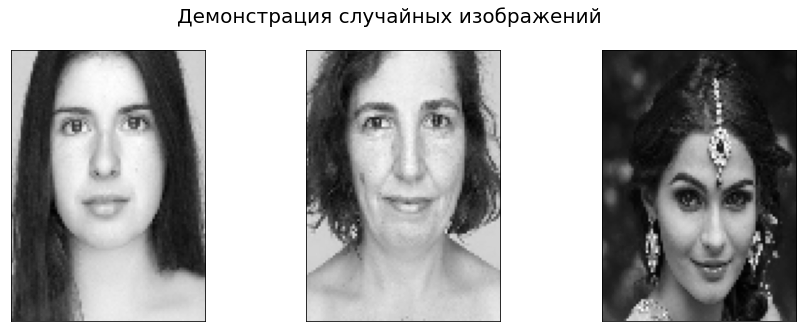

In [ ]:
num = 3 # число изображений для демонстрации
 
fig, ax = plt.subplots(1, num, figsize=(15, 5)) # создание полотна из k графиков
fig.suptitle("Демонстрация случайных изображений", y=1, size=20)

for i in range(num):
  name_img = np.random.choice(os.listdir(img_dir)) # выбираем случайное фото для демонстрации
  path_img = img_dir + '/' + name_img
  img = image.load_img(path=path_img, color_mode='grayscale', target_size=(img_height, img_width))

  ax[i].get_xaxis().set_visible(False)
  ax[i].get_yaxis().set_visible(False)
  ax[i].imshow(img, cmap='gray')

plt.show()

## **2.) Реализация необходимых функций**

### **Загрузка изображений**

In [ ]:
def images_load():
  img_list = [] # Список для хранения изображений
  path = img_dir
  faces = os.listdir(img_dir) # названия файлов

  for img in faces:
    curr_path = os.path.join(path,img)
    curr_img = image.load_img(curr_path, target_size=(img_height, img_width), color_mode="grayscale")
    img_list.append(image.img_to_array(curr_img))

  return np.array(img_list)

### **Нанесение чёрных областей на изображение**


In [ ]:
def add_black_area(img, max_k, max_l): # максимальное число областей, максимальная ширина области
  img = image.array_to_img(img)
  k = rd.randint(1,max_k)
  draw = ImageDraw.Draw(img) # инструмент для изображения фигур

  for _ in range(k):
    # Положение левого верхнего угла очередной области
    curr_x = rd.randint(0,img_width-1)
    curr_y = rd.randint(0,img_height-1)
    
    # Ширина очередной области
    curr_l = rd.randint(1,max_l)
    # Проверка на выход за границы изображения
    curr_l = np.where(((curr_l > img_width - curr_x) or (curr_l > img_height - curr_y)), min((img_width - curr_x), (img_height - curr_y)), curr_l)
    # Отрисовка чёрного квадрата
    draw.rectangle((curr_x, curr_y, curr_x + curr_l, curr_y + curr_l), fill = 'black')

  img = image.img_to_array(img)
  return img
    

### **Формирование выборок для нейросети**

In [ ]:
def create_sets(max_k, max_l):
  x_data = []  # Список для хранения изображений с тёмными областями
  y_data = images_load() # исходные изображения

  for img in y_data:
    img_tr = add_black_area(img, max_k, max_l) # Наносим тёмные области на фото
    x_data.append(img_tr)

  x_data = np.array(x_data) / 255.
  y_data = np.array(y_data) / 255.

  return x_data, y_data

### **Сравнение изображений**

In [ ]:
def compare_imgs (data, data_tr, k = 5):
  n = data.shape[0]

  fig, ax = plt.subplots(nrows=2, ncols=k, figsize=(14,10))
  fig.suptitle("Демонстрация изображений", y=0.9, size=18)
  for i in range(k):
    r = np.random.randint(0,n-1)
    curr_img = data[r].reshape(img_height, img_width)
    curr_img_tr = data_tr[r].reshape(img_height, img_width)
    ax[0][i].imshow(curr_img, cmap='gray')
    ax[1][i].imshow(curr_img_tr, cmap='gray')
    ax[0][i].get_xaxis().set_visible(False)
    ax[0][i].get_yaxis().set_visible(False)
    ax[1][i].get_xaxis().set_visible(False)
    ax[1][i].get_yaxis().set_visible(False)

  plt.show()


### **Архитектура автокодировщика**

In [ ]:
'''
1.) Архитектура автокодировщика подобрана под конкретную задачу, 
поэтому она не обладает свойством гибкости.

2.) Блоки энкодера и декодера не связаны между собой, как в семействе U-Net архитектур.

3.) Для снижения размерности используется слой MaxPooling2D(), для повышения - Conv2DTranspose()

'''

def create_autoencoder(shape):
  #Модель encoder
  in_encod = Input(shape = shape)

  encod = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(in_encod) # shape - (112,80,32)
  encod = BatchNormalization()(encod)
  encod = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(encod) # shape - (112,80,32)
  encod = BatchNormalization()(encod)
  encod = MaxPooling2D(pool_size=(2,2), strides=(2,2))(encod) # shape - (56, 40, 32)

  encod = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(encod) # shape - (56,40,64)
  encod = BatchNormalization()(encod)
  encod = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(encod) # shape - (56,40,64)
  encod = BatchNormalization()(encod)
  out_encod = MaxPooling2D(pool_size=(2,2), strides=(2,2))(encod) # shape - (28, 20, 64)

  encoder = Model(in_encod, out_encod)


  #Модель decoder
  in_decod = Input(shape = (28, 20, 64))

  decod = Reshape((28,20,64))(in_decod) # shape - (28, 20, 64)
  
  decod = Conv2DTranspose(64, kernel_size=(2,2), strides=(2,2))(decod) # shape - (56,40,64)
  decod = BatchNormalization()(decod)

  decod = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(decod) # shape - (56,40,64)
  decod = BatchNormalization()(decod)
  decod = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(decod) # shape - (56,40,64)
  decod = BatchNormalization()(decod)

  decod = Conv2DTranspose(32, kernel_size=(2,2), strides=(2,2))(decod) # shape - (112,80,32)
  decod = BatchNormalization()(decod)
  decod = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(decod) # shape - (56,40,32)
  decod = BatchNormalization()(decod)
  decod = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(decod) # shape - (56,40,32)
  decod = BatchNormalization()(decod)

  out_decod = Conv2D(1, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(decod) # shape - (56,40,1)

  decoder = Model(in_decod, out_decod)

  autoencoder = Model(in_encod, decoder(encoder(in_encod))) # Формирование связанной архитектуры

  return autoencoder, encoder, decoder

### **Реализация CallBack**

In [ ]:
def get_callback(saved_file):
  # saved_file = "autoencoders.h5"
  best_weights = ModelCheckpoint(
    saved_file,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_weights_only = True # сохранение только весов
    )
  
  return best_weights

### **Тренировка нейронной сети**

In [ ]:
def model_training(model, initial_epoch, epochs, learning_rate, bool_callback, batch_size):
  # Использование преобученных весов
  use_weights = input("Использовать предобученные веса? (Да/Нет) - ")
  if use_weights == "Да":
    weights_path = input("Путь к расположению весов - ")
    model.load_weights(weights_path)

  # Использование callback для сохранения весов
  if bool_callback == "Да":
    saved_file = f"autoencoder_lr_{learning_rate}_ep_{initial_epoch}_{epochs}.h5"
    best_weights = get_callback(saved_file)
  else:
    best_weights = None

  # Компиляция нейронной сети
  model.compile(
    optimizer = Adam(learning_rate=1e-5),
    loss = "mse"
  )

  # Тренировка нейронной сети
  history = model.fit(
    x_train,
    y_train,
    batch_size = batch_size,
    initial_epoch = initial_epoch,
    epochs = epochs,
    validation_data = (x_val, y_val),
    callbacks = best_weights,
    verbose = 1
  )

  return history

### **Построение графика ошибки при обучении модели**

In [ ]:
def plot_mse(history):
  fig, ax = plt.subplots(figsize=(12,7))
  fig.suptitle("Ошибка (mse) в процессе обучения", y=1, size=20)
  
  ax.plot(history.history["loss"], label = "тренировочные данные")
  ax.plot(history.history["val_loss"], label = "проверочные данные")
  ax.set_xlabel("Количество эпох", size = 12)
  ax.set_ylabel("Ошибка mse", size = 12)
  ax.legend(prop={"size":12})

  plt.show()

### **Вычисление среднеквадратичной ошибки**

In [ ]:
def get_mse(img1, img2):
  fl_img1 = img1.flatten()
  fl_img2 = img2.flatten()
  l = len(fl_img1)
  mse = sum((fl_img1 - fl_img2)**2)/l

  return mse

### **Отрисовка изображений**

In [ ]:
def plot_img(img):
  img = img.reshape(img_height, img_width)
  plt.imshow(img, cmap='gray')
  plt.axis('off') # Отключение осей
  plt.show()

### **Оценка работы сети на тестовой выборке**

In [ ]:
def check_on_test(model, x_test, y_test, k_imgs):
  pred = model.predict(x_test)

  compare_imgs(x_test, pred, k_imgs) # отрисовка изображений
  
  l = x_test.shape[0] # Число записей
  med_mse = 0
  min_mse = sys.maxsize
  max_mse = 0

  for i in range(l):
    curr_mse = get_mse(pred[i], y_test[i])
    med_mse += curr_mse
    min_mse = np.where(curr_mse < min_mse, curr_mse, min_mse)
    max_mse = np.where(curr_mse > max_mse, curr_mse, max_mse)

  med_mse = np.round(med_mse/l, 4) # Среднее значение mse по всей выборке
  min_mse = np.round(min_mse, 4)
  max_mse = np.round(max_mse, 4)

  # Показатели mse на тестовой выборке
  print("\033[1mПоказатели mse на тестовой выборке\033[0m")
  print(f"\033[1mСреднее значение ошибки\033[0m - {med_mse}")
  print(f"\033[1mМинимальное значение ошибки\033[0m - {min_mse}")
  print(f"\033[1mМаксимальное значение ошибки\033[0m - {max_mse}")

## **3.) Реализация алгоритма обучения**

### **Формирование выборок**

In [ ]:
max_k = int(input("Максимальное число чёрных областей на фото - "))
max_l = int(input("Максимальная ширина чёрной области - "))
x_data, y_data = create_sets(max_k, max_l)

Максимальное число чёрных областей на фото - 5
Максимальная ширина чёрной области - 25


Число изображений для отображения - 5


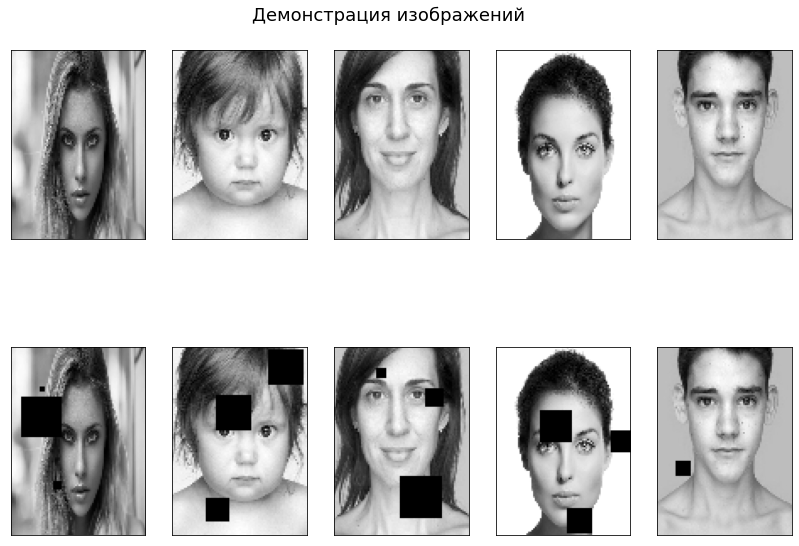

In [ ]:
n_imgs = int(input("Число изображений для отображения - "))
compare_imgs(y_data, x_data, n_imgs)

In [ ]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x_data, y_data, test_size = 0.1, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size = 0.2, shuffle=True)

In [ ]:
print(f"Размер data_train - {x_train.shape}")
print(f"Размер data_val - {x_val.shape}")
print(f"Размер data_test - {x_test.shape}")

Размер data_train - (3612, 112, 80, 1)
Размер data_val - (904, 112, 80, 1)
Размер data_test - (502, 112, 80, 1)


### **Структура нейронной сети**

In [ ]:
autoencoder, encoder, decoder = create_autoencoder(shape)

In [ ]:
print("\033[1mОбщая структура\033[0m")
autoencoder.summary()

Общая структура
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 80, 1)]      0         
                                                                 
 model (Functional)          (None, 28, 20, 64)        65760     
                                                                 
 model_1 (Functional)        (None, 112, 80, 1)        118465    
                                                                 
Total params: 184,225
Trainable params: 183,265
Non-trainable params: 960
_________________________________________________________________


Структура encoder


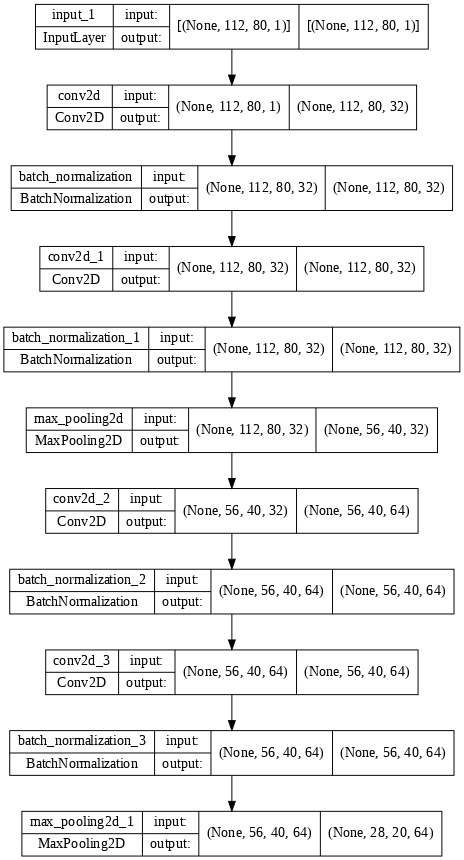

In [ ]:
print("\033[1mСтруктура encoder\033[0m")
utils.plot_model(encoder, show_shapes=True, dpi=70)

Структура decoder


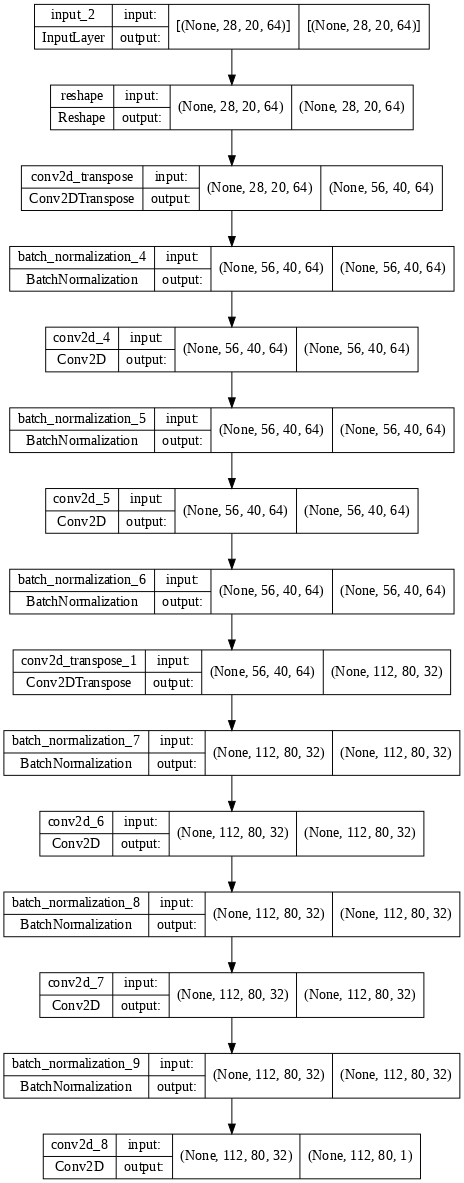

In [ ]:
print("\033[1mСтруктура decoder\033[0m")
utils.plot_model(decoder, show_shapes=True, dpi=70)

### **Обучения модели (1-й этап)**

In [ ]:
epochs = int(input("Количество эпох обучения - "))
initial_epoch = int(input("Стартовая эпоха обучения - "))
learning_rate = float(input("Шаг обучения - "))
bool_callback = input("Необходимо ли сохранять веса с наилучшими показателями? (Да/Нет) - ")
batch_size = int(input("Размер батча - "))

Количество эпох обучения - 150
Стартовая эпоха обучения - 0
Шаг обучения - 1e-5
Необходимо ли сохранять веса с наилучшими показателями? (Да/Нет) - Да
Размер батча - 32


In [ ]:
history = model_training(autoencoder, initial_epoch, epochs, learning_rate, bool_callback, batch_size)

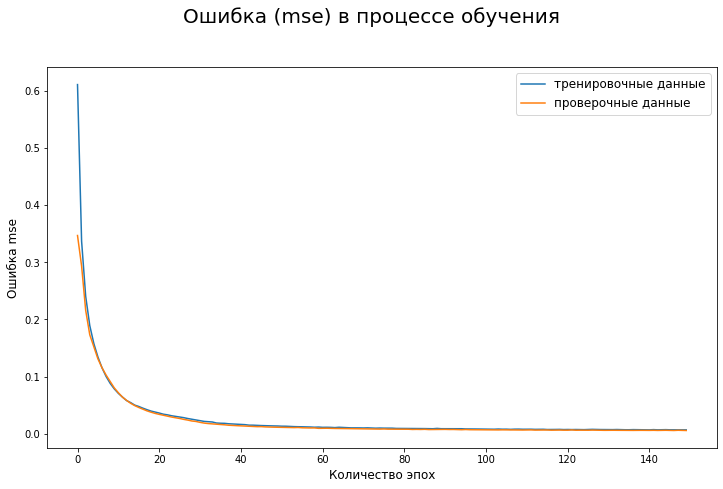

In [ ]:
plot_mse(history)

### **Оценка качества работы сети (1-й этап)**

In [ ]:
k_imgs = int(input("Число изображений для демонстрации - "))

Число изображений для демонстрации - 5


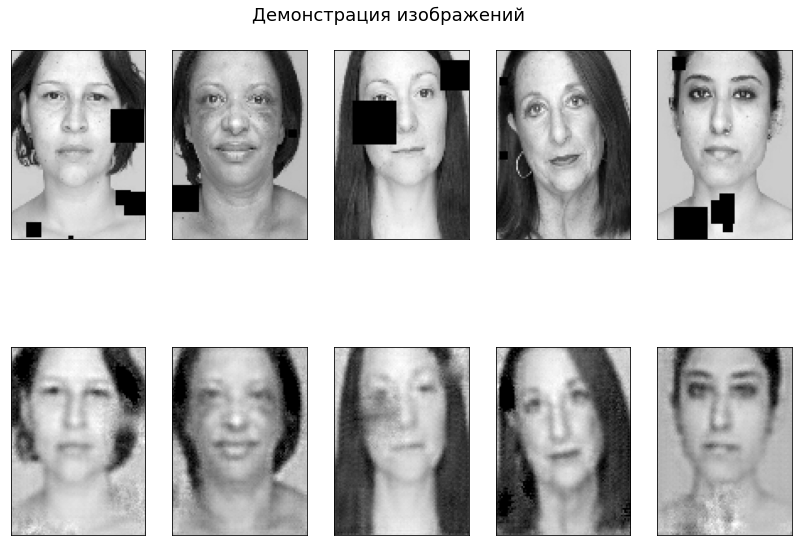

Показатели mse на тестовой выборке
Среднее значение ошибки - 0.0065
Минимальное значение ошибки - 0.0012
Максимальное значение ошибки - 0.178


In [ ]:
check_on_test(autoencoder, x_test, y_test, k_imgs)

### **Обучение модели (2-й этап)**

In [ ]:
epochs = int(input("Количество эпох обучения - "))
initial_epoch = int(input("Стартовая эпоха обучения - "))
learning_rate = float(input("Шаг обучения - "))
bool_callback = input("Необходимо ли сохранять веса с наилучшими показателями? (Да/Нет) - ")
batch_size = int(input("Размер батча - "))

Количество эпох обучения - 250
Стартовая эпоха обучения - 150
Шаг обучения - 5e-7
Необходимо ли сохранять веса с наилучшими показателями? (Да/Нет) - Да
Размер батча - 32


In [ ]:
history = model_training(autoencoder, initial_epoch, epochs, learning_rate, bool_callback, batch_size)

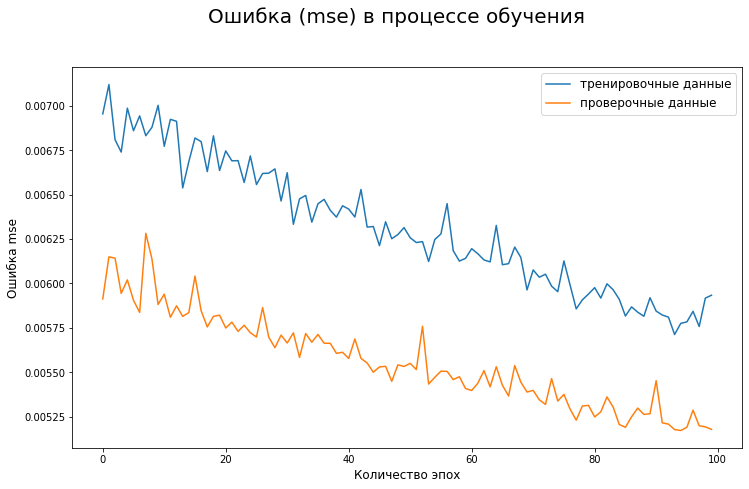

In [ ]:
plot_mse(history)

### **Оценка качества работы сети (2-й этап)**

In [ ]:
k_imgs = int(input("Число изображений для демонстрации - "))

Число изображений для демонстрации - 5


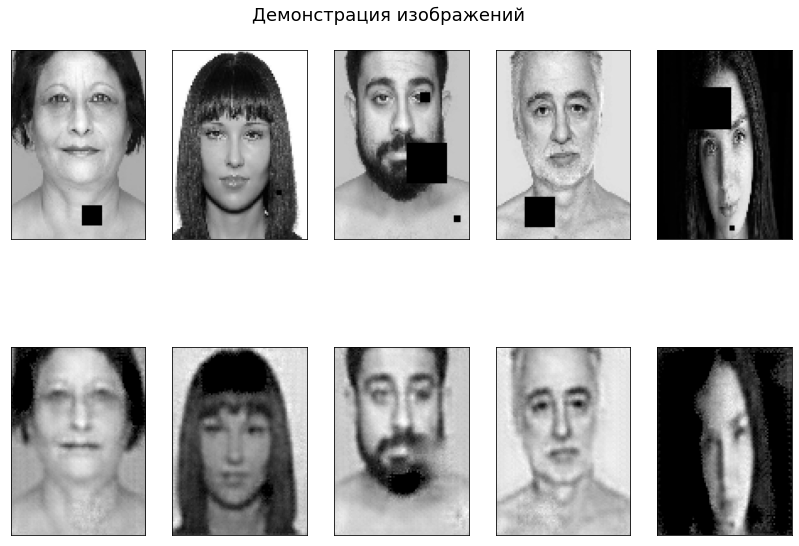

Показатели mse на тестовой выборке
Среднее значение ошибки - 0.0057
Минимальное значение ошибки - 0.0011
Максимальное значение ошибки - 0.1749


In [ ]:
check_on_test(autoencoder, x_test, y_test, k_imgs)

## **4.) Выводы**



> #### 1.   Для сохранения формата исходного изображения при использовании свёрток нужно использовать strides=(1,1) и padding="same".
> #### 2.   Нужно обязательно делать нормировку изображений перед подачей в нейронную сеть.
> #### 3.   Разворачивание изображения в вектор приводит к увеличению vall_loss примерно в 10 раз.
> #### 4.   При попытке удаления чёрных областей с фото данные области получаются более размытыми, чем всё остальное изображение. Думаю, большей точности можно добиться засчёт усложнения архитектуры нейронной сети
> #### 5.   Как видно из графиков обучения, на 2-м этапе ошибка продолжает уменьшаться, хоть и довольно медленно. Возможно, стоит уменьшить batch_size и learning_rate 

